# Setting Config

In [1]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "0"
model_name = 'DeepvoiceDetector_epoch99'
cuda = 'cuda:0'
max_length = 512

# Load Data

In [2]:
dataset = {'real' : {
            'label' : 'real',
            'wav' : '/root/NetChallenge10/dataset/real.wav',
            'text' : '이미 구속영장까지 발부되어 있어서 대출이 안될겁니다. 본인 명의가 범죄에 연루되었는지 확인해보는 차원에서 한번 대출을 받아서 송금을 해봐야 할 것 같습니다.'
        },
        'fake' : {
            'label' : 'fake',
            'wav' : '/root/NetChallenge10/dataset/fake.wav',
            'text' : '이미 구속영장까지 발부되어 있어서 대출이 안될겁니다. 본인 명의가 범죄에 연루되었는지 확인해보는 차원에서 한번 대출을 받아서 송금을 해봐야 할 것 같습니다.'
        }}

labels = ['real', 'fake']

# Load Model

In [3]:
import torch
from merdataset import *
from config import *
from utils import *

model = torch.load('./ckpt/{}.pt'.format(model_name))
softmax = torch.nn.Softmax(dim=0)

model.eval()


/usr/local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Kwav2vec_classfier(
  (classifier): Sequential(
    (0): Dropout(p=0.1, inplace=False)
    (1): Linear(in_features=768, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=512, out_features=2, bias=True)
  )
  (projection): Conv1d(1024, 768, kernel_size=(1,), stride=(1,), bias=False)
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

# DevoX

## Voice Choice

In [4]:
# 실제 음성 데이터
#data = dataset['real']

# 딥보이스 데이터
data = dataset['fake']

### Data Check

스크립트: 이미 구속영장까지 발부되어 있어서 대출이 안될겁니다. 본인 명의가 범죄에 연루되었는지 확인해보는 차원에서 한번 대출을 받아서 송금을 해봐야 할 것 같습니다.


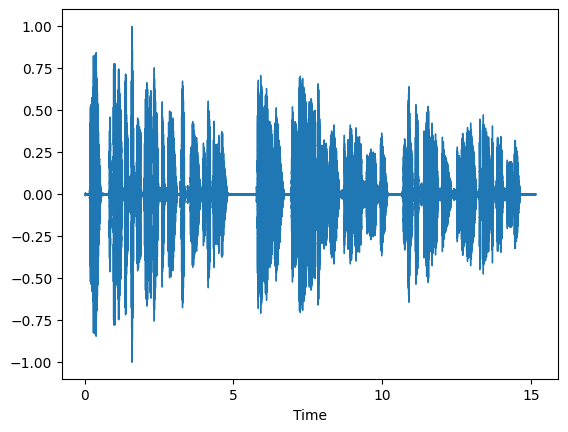

In [5]:
import librosa
import soundfile as sf
from IPython.display import Audio, display
print('스크립트:',data['text'])

# 음성 재생
audio = Audio(data['wav'], autoplay=True)
display(audio)

# 푸리에 변환
wav, _ = sf.read(data['wav'])
librosa.display.waveshow(wav)

### Feature Extraction

In [10]:
def Feature_Extraction(model, data):
    hidden_batch = torch.Tensor().to(cuda)

    hidden = model.audio_encoder.encoding_one_data(data)
    print(hidden.shape)
    seq = hidden.size()[1]

    if seq > max_length:
        # truncation
        hidden = hidden[:,:max_length,:].to(cuda)
    elif seq < max_length:
        # padding
        pad = torch.Tensor([[[0]*1024]*(max_length-seq)]).to(cuda)
        hidden = torch.cat([hidden,pad], dim=1)

    hidden_batch = torch.cat([hidden_batch,hidden],dim=0)

    return hidden_batch

torch.Size([1, 1043, 1024])
torch.Size([1, 512, 1024])
Feature 추출 시간: 0.421 초


Text(0.5, 1.0, 'pooled_hidden')

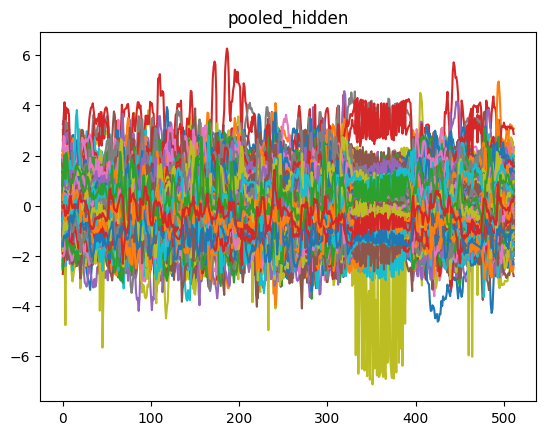

In [11]:
import matplotlib.pyplot as plt
import time

start = time.time()

pooled_hidden = Feature_Extraction(model, data)
print(pooled_hidden.shape)
end = time.time()
print('Feature 추출 시간:', round(end-start, 3), '초')
plt.plot(pooled_hidden.tolist()[0])
plt.title('pooled_hidden')


### DevoX Inference

In [8]:
def DevoX_Inference(model, audio_out):
    audio_out = model._conv1d(audio_out)
    audio_out = audio_out.transpose(1, 2)
        
    audio_out = model.avgpool(audio_out)
    audio_out = torch.squeeze(audio_out)

    return model.classifier(audio_out)


In [9]:
import time

start = time.time()
print('딥보이스 일까요?')
print('정답:', data['label'])

outputs = DevoX_Inference(model, pooled_hidden)
outputs = softmax(outputs)
print('DevoX:',labels[torch.argmax(outputs)])

end = time.time()
print('추론시간:', round(end-start, 3),'초')
print()


딥보이스 일까요?
정답: fake
DevoX: fake
추론시간: 0.018 초

